In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.api as sm

In [2]:
path = r"C:\Users\ALI\Desktop\hamsi\hamsi.xlsx"
df = pd.read_excel(path)
print(df.columns)
data = df.iloc[:, 2:-3].dropna()
print(data.columns)

Index(['Tag', 'Date & Time', 'Temp (C)', 'Baro (mb)', 'Depth (m)', 'pH',
       'pHmV', 'ORP (REDOX)', 'DO (% Sat)', 'DO (mg/L)', 'EC (uS/cm @25C)',
       'RES (Ohms.cm)', 'TDS (mg/L)', 'SAL (PSU)', 'Turbidity (NTU)',
       'CDOM (ug/L)', 'Chlorophyll (ug/L)', 'Lat', 'Lon', 'Alt (m)'],
      dtype='object')
Index(['Temp (C)', 'Baro (mb)', 'Depth (m)', 'pH', 'pHmV', 'ORP (REDOX)',
       'DO (% Sat)', 'DO (mg/L)', 'EC (uS/cm @25C)', 'RES (Ohms.cm)',
       'TDS (mg/L)', 'SAL (PSU)', 'Turbidity (NTU)', 'CDOM (ug/L)',
       'Chlorophyll (ug/L)'],
      dtype='object')


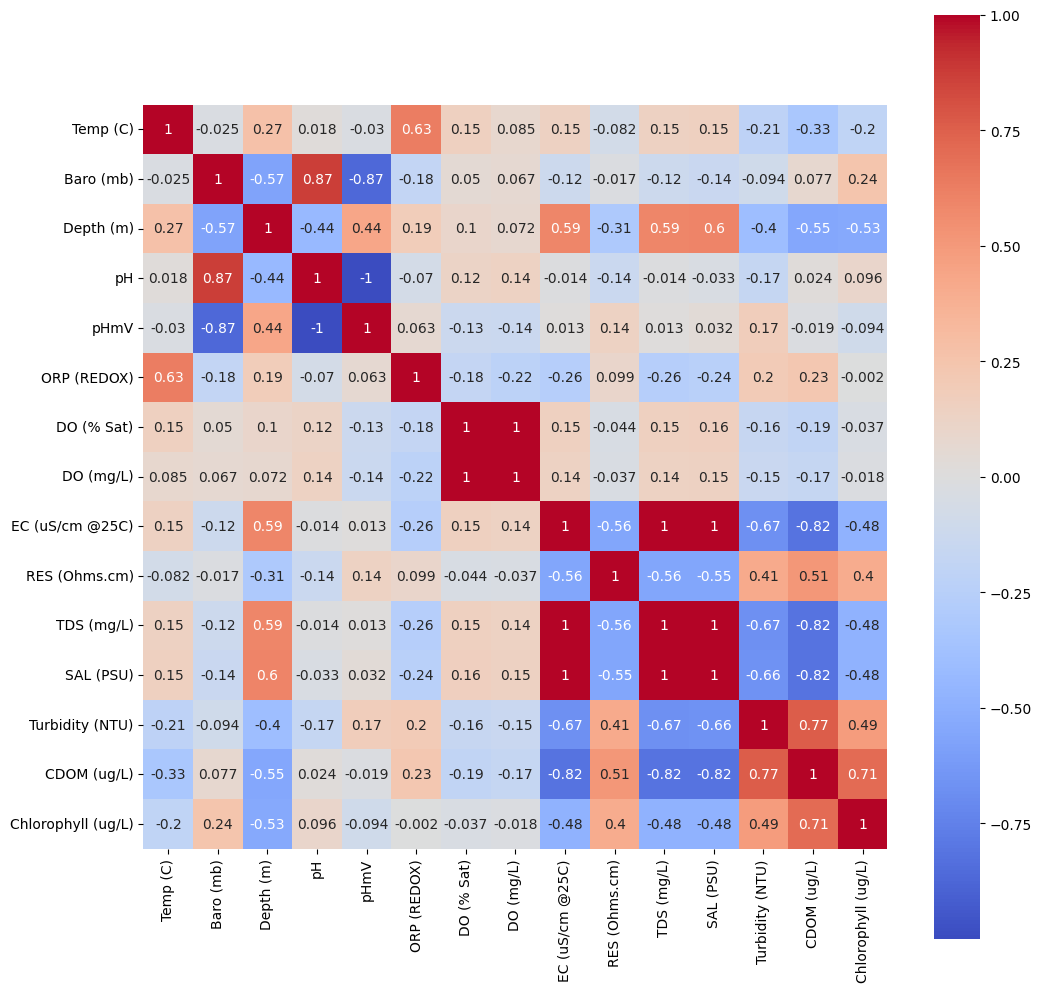

In [3]:
corr_matrix = data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.show()

In [4]:
remove_columns = ["pHmV", 'EC (uS/cm @25C)', 'TDS (mg/L)']
data = data.drop(columns=remove_columns)
data.columns

Index(['Temp (C)', 'Baro (mb)', 'Depth (m)', 'pH', 'ORP (REDOX)', 'DO (% Sat)',
       'DO (mg/L)', 'RES (Ohms.cm)', 'SAL (PSU)', 'Turbidity (NTU)',
       'CDOM (ug/L)', 'Chlorophyll (ug/L)'],
      dtype='object')

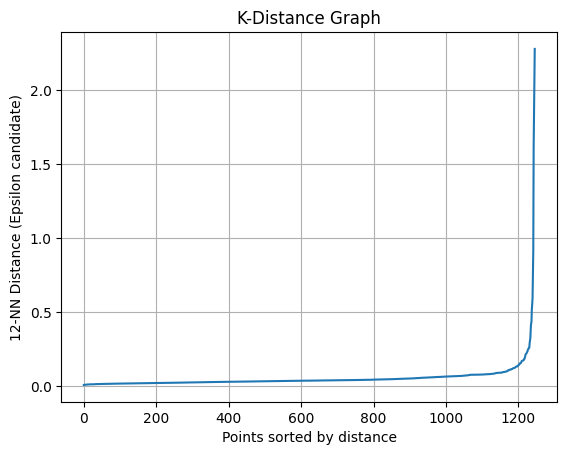

In [5]:
data_norm = MinMaxScaler().fit_transform(data)
D = len(data.columns)

k = D
# Calculate distance to the k-th nearest neighbor
nbrs = NearestNeighbors(n_neighbors=k).fit(data_norm)
distances, indices = nbrs.kneighbors(data_norm)

# Sort distance to the k-th neighbor (column index k-1)
sorted_distances = np.sort(distances[:, k-1])

# Plot
plt.plot(sorted_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-NN Distance (Epsilon candidate)")
plt.title("K-Distance Graph")
plt.grid(True)
plt.show()

In [6]:
epsilon = sorted_distances[1200]

dbscan_e = DBSCAN(eps=epsilon, min_samples=15, algorithm="auto", metric='euclidean', n_jobs=-1)
dbscan_m = DBSCAN(eps=epsilon, min_samples=15, algorithm="auto", metric='manhattan', n_jobs=-1)
dbscan_c = DBSCAN(eps=epsilon, min_samples=15, algorithm="auto", metric='cosine', n_jobs=-1)
#dbscan_mh = DBSCAN(eps=0.18, min_samples=15, algorithm="auto", metric='mahalanobis', n_jobs=-1)

density_e = dbscan_e.fit_predict(data_norm)
density_m = dbscan_m.fit_predict(data_norm)
density_c = dbscan_c.fit_predict(data_norm)
#density_mh = dbscan_mh.fit_predict(data_norm)

print(pd.Series(dbscan_e.labels_).value_counts())
print(pd.Series(dbscan_m.labels_).value_counts())
print(pd.Series(dbscan_c.labels_).value_counts())
#print(pd.Series(dbscan_mh.labels_).value_counts())

 1    907
 0    300
-1     39
Name: count, dtype: int64
 2    890
 1    240
-1     88
 0     28
Name: count, dtype: int64
 0    1243
-1       3
Name: count, dtype: int64


In [7]:
results = []
densities = [density_e, density_m, density_c]
labels = [dbscan_e.labels_, dbscan_m.labels_, dbscan_c.labels_]
metrics = ["euclidean", "manhattan", "cosine"]

for i in range((len(densities))):
    # 1. Gürültü Oranı (Noise Ratio) - Çok Önemli!
    noise_ratio = np.sum(labels[i] == -1) / len(labels[i])

    # 2. Silhouette Score (Modelin kendi metriğiyle hesaplanır)
    # Cosine modelini Cosine mesafesiyle değerlendiriyoruz
    score = silhouette_score(data_norm, labels[i], metric=metrics[i])

    results.append({
        'Model': metrics[i],
        'Silhouette Score': score,
        'Clusters Found': len(set(labels[i])) - (1 if -1 in labels[i] else 0),
        'Noise Ratio': f"%{noise_ratio*100:.1f}"
    })

# Sonuçları Tablo Olarak Göster
df_results = pd.DataFrame(results).sort_values(by='Silhouette Score', ascending=False)
print(df_results)

       Model  Silhouette Score  Clusters Found Noise Ratio
2     cosine          0.918034               1        %0.2
0  euclidean          0.747860               2        %3.1
1  manhattan          0.566492               3        %7.1


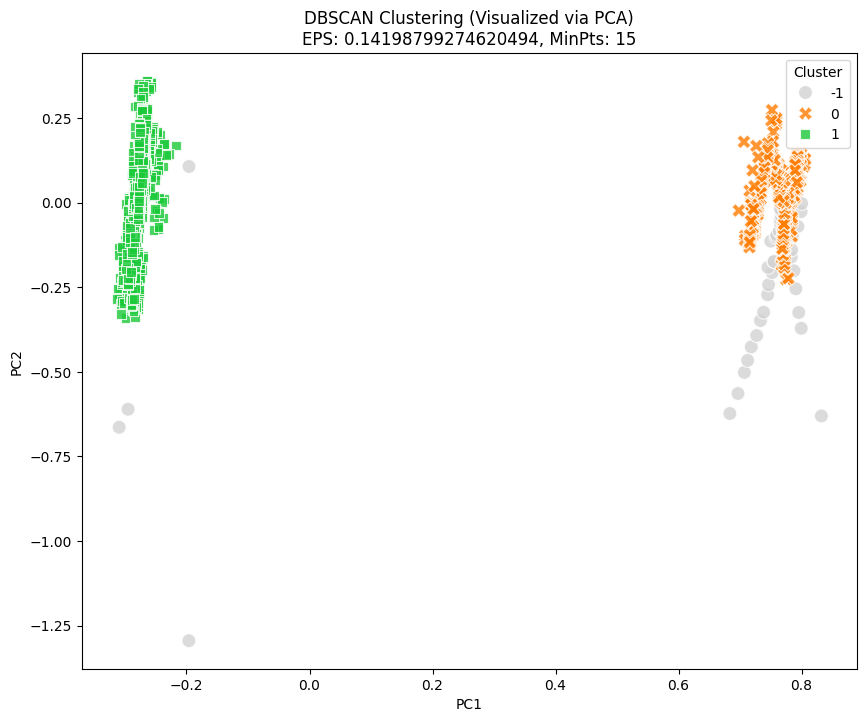

In [8]:
# 1. Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_norm)  # Use your scaled data!

# 2. Create a DataFrame for plotting
df_plot = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_plot['Cluster'] = dbscan_e.labels_  # 'labels' comes from dbscan.fit_predict()

# 3. Setup the Plot
plt.figure(figsize=(10, 8))

# Define colors: Use a specific palette, but make sure Noise (-1) is distinct (e.g., Grey)
unique_labels = sorted(df_plot['Cluster'].unique())
palette = sns.color_palette("bright", len(unique_labels))

# If Noise exists, let's map it to a specific dull color (like black or grey)
# and clusters to bright colors
color_dict = dict(zip(unique_labels, palette))
if -1 in color_dict:
    color_dict[-1] = 'lightgrey'  # Make noise less distracting

# 4. Plot
sns.scatterplot(
    data=df_plot, 
    x='PC1', 
    y='PC2', 
    hue='Cluster', 
    palette=color_dict,
    style='Cluster',      # Different shapes for different clusters
    s=100,                # Dot size
    alpha=0.8,            # Transparency
    edgecolor='w'
)

plt.title(f'DBSCAN Clustering (Visualized via PCA)\nEPS: {dbscan_e.eps}, MinPts: {dbscan_e.min_samples}')
plt.show()

In [9]:
iso_forest = IsolationForest(
    n_estimators=100,         # Yeterli (fazlası gereksiz)
    max_samples=256,          # MAKALENİN SIRRI: "Sub-sampling" başarımı artırır!
    contamination=0.05,       # Verinin %5'i anomali varsayıyoruz (tahmini)
    random_state=42,
    n_jobs=-1
)

# Eğit ve Tahmin Et
iso_forest.fit(data_norm)
labels = iso_forest.predict(data_norm) 
# Çıktı: 1 (Normal), -1 (Anomali)

# SKORLARI AL (Daha Derin Analiz İçin)
# Skor ne kadar düşükse (negatif), o kadar anormaldir.
scores = iso_forest.decision_function(data_norm)

# Sonuçları İncele
n_anomalies = np.sum(labels == -1)
print(f"Tespit edilen anomali sayısı: {n_anomalies}")

# Anomalilerin en 'kötü' olanlarını bul
# Skorları ve indeksleri eşleştirip en düşük skorlu 5'i yazdır
anomaly_indices = np.argsort(scores)[:5]
print("En yüksek anomali skoruna sahip 5 veri noktasının indeksleri:", anomaly_indices)

Tespit edilen anomali sayısı: 63
En yüksek anomali skoruna sahip 5 veri noktasının indeksleri: [1245 1244   22 1243    0]


In [10]:
data["Isolation"] = labels
data["Density"] = density_e

In [11]:
# Create masks for anomalies in each model
mask_db = (data["Density"] == -1)
mask_iso = (data["Isolation"] == -1)

# Find rows where BOTH are anomalies (The Intersection)
# This is the "Bad Data" mask
intersection_mask = mask_db & mask_iso

# Filter: Keep rows that are NOT (~) in the intersection
data_clean = data[~intersection_mask].reset_index(drop=True)

print(f"Original shape: {data.shape}")
print(f"Cleaned shape:  {data_clean.shape}")
print(f"Dropped rows:   {data.shape[0] - data_clean.shape[0]}")

Original shape: (1246, 14)
Cleaned shape:  (1208, 14)
Dropped rows:   38


In [12]:
for i in range(len(data_clean.columns)):
    print(i, data_clean.columns[i])

0 Temp (C)
1 Baro (mb)
2 Depth (m)
3 pH
4 ORP (REDOX)
5 DO (% Sat)
6 DO (mg/L)
7 RES (Ohms.cm)
8 SAL (PSU)
9 Turbidity (NTU)
10 CDOM (ug/L)
11 Chlorophyll (ug/L)
12 Isolation
13 Density


In [13]:
X = data_clean.iloc[:, [0,1,2,3,4,7,8,9,10,11]]
y = data_clean.iloc[:, 5]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=430)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [14]:
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

print("=== Training Performance ===")
print(f"R2 Score: {r2_score(y_train, y_pred_train):.4f}")
print(f"MSE: {mean_squared_error(y_train, y_pred_train):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")

print("\n=== Test Performance ===")
print(f"R2 Score: {r2_score(y_test, y_pred_test):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")

# Add constant for statsmodels
X_train_with_const = sm.add_constant(X_train_scaled)

# Fit OLS model to get p-values
ols_model = sm.OLS(y_train, X_train_with_const).fit()
print(ols_model.summary())

=== Training Performance ===
R2 Score: 0.4162
MSE: 14.8007
RMSE: 3.8472

=== Test Performance ===
R2 Score: 0.4161
MSE: 15.9225
RMSE: 3.9903
                            OLS Regression Results                            
Dep. Variable:             DO (% Sat)   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     68.07
Date:                Mon, 08 Dec 2025   Prob (F-statistic):          1.70e-104
Time:                        12:28:35   Log-Likelihood:                -2672.2
No. Observations:                 966   AIC:                             5366.
Df Residuals:                     955   BIC:                             5420.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025   

In [15]:
# 1. Veri Seçimi ve Bölme (Aynı kalıyor)
X = data_clean.iloc[:, [0,1,2,3,4,7,8,9,10,11]]
y = data_clean.iloc[:, 5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=460)

# 2. POLİNOM ÖZELLİKLERİ (Scaling'den ÖNCE!)
# degree=2 genelde en güvenlisidir. 3 ve üzeri overfitting riskini çok artırır.
# include_bias=False diyoruz çünkü LinearRegression() kendi bias'ını zaten ekler.
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# 3. ÖLÇEKLENDİRME (Artık genişletilmiş veri setini ölçekliyoruz)
scaler = StandardScaler()

# Poly uygulanmış veri üzerine fit edip dönüştürüyoruz
X_train_final = scaler.fit_transform(X_train_poly)
X_test_final = scaler.transform(X_test_poly)

# 4. MODEL EĞİTİMİ
model = LinearRegression()
model.fit(X_train_final, y_train)

print(f"Orijinal Özellik Sayısı: {X_train.shape[1]}")
print(f"Polinom Sonrası Özellik Sayısı: {X_train_final.shape[1]}")

y_pred_train = model.predict(X_train_final)
y_pred_test = model.predict(X_test_final)

print("=== Training Performance ===")
print(f"R2 Score: {r2_score(y_train, y_pred_train):.4f}")
print(f"MSE: {mean_squared_error(y_train, y_pred_train):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")

print("\n=== Test Performance ===")
print(f"R2 Score: {r2_score(y_test, y_pred_test):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")

# Add constant for statsmodels
X_train_with_const = sm.add_constant(X_train_final)

# Fit OLS model to get p-values
ols_model = sm.OLS(y_train, X_train_with_const).fit()
print(ols_model.summary())

Orijinal Özellik Sayısı: 10
Polinom Sonrası Özellik Sayısı: 65
=== Training Performance ===
R2 Score: 0.8395
MSE: 4.0997
RMSE: 2.0248

=== Test Performance ===
R2 Score: 0.8109
MSE: 5.0046
RMSE: 2.2371
                            OLS Regression Results                            
Dep. Variable:             DO (% Sat)   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     73.66
Date:                Mon, 08 Dec 2025   Prob (F-statistic):          3.00e-312
Time:                        12:28:35   Log-Likelihood:                -2052.2
No. Observations:                 966   AIC:                             4234.
Df Residuals:                     901   BIC:                             4551.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
        

In [16]:
# 1. RECOVER FEATURE NAMES
# We need the original column names to generate poly names (e.g., 'Age^2')
input_cols = X.columns
poly_col_names = poly.get_feature_names_out(input_cols)

# 2. CONVERT TO DATAFRAME (Crucial for dropping columns by name)
# We reset index to avoid alignment issues
X_train_df = pd.DataFrame(X_train_final, columns=poly_col_names, index=y_train.index)
X_test_df = pd.DataFrame(X_test_final, columns=poly_col_names, index=y_test.index)

X_train_df_2 = X_train_df.copy()
X_test_df_2 = X_test_df.copy()

# 3. BACKWARD ELIMINATION LOGIC
significance_level = 0.05

while True:
    # Statsmodels requires explicitly adding a constant (intercept)
    X_with_const = sm.add_constant(X_train_df)
    
    # Fit OLS Model
    ols_model = sm.OLS(y_train, X_with_const).fit()
    
    # Get P-values (exclude 'const' from elimination candidates)
    p_values = ols_model.pvalues.drop('const')
    
    # Find the worst feature
    max_p_value = p_values.max()
    worst_feature = p_values.idxmax()
    
    if max_p_value > significance_level:
        print(f"Dropping: {worst_feature} (p-value: {max_p_value:.4f})")
        # Drop from both Train and Test dataframes to keep them synced
        X_train_df.drop(columns=worst_feature, inplace=True)
        X_test_df.drop(columns=worst_feature, inplace=True)
    else:
        print("\n--- Elimination Complete ---")
        print(f"All remaining features have p-value < {significance_level}")
        break

# 4. FINAL SUMMARY
print(ols_model.summary())

Dropping: Depth (m) (p-value: 0.9604)
Dropping: Turbidity (NTU) CDOM (ug/L) (p-value: 0.8900)
Dropping: Temp (C) SAL (PSU) (p-value: 0.8755)
Dropping: Temp (C) pH (p-value: 0.8294)
Dropping: ORP (REDOX) SAL (PSU) (p-value: 0.7182)
Dropping: Baro (mb) RES (Ohms.cm) (p-value: 0.7305)
Dropping: Baro (mb) SAL (PSU) (p-value: 0.8535)
Dropping: Depth (m) Chlorophyll (ug/L) (p-value: 0.6243)
Dropping: pH RES (Ohms.cm) (p-value: 0.5999)
Dropping: ORP (REDOX) Turbidity (NTU) (p-value: 0.5836)
Dropping: CDOM (ug/L)^2 (p-value: 0.6429)
Dropping: ORP (REDOX) RES (Ohms.cm) (p-value: 0.5318)
Dropping: Temp (C) Turbidity (NTU) (p-value: 0.4681)
Dropping: ORP (REDOX) Chlorophyll (ug/L) (p-value: 0.4507)
Dropping: SAL (PSU) Turbidity (NTU) (p-value: 0.3789)
Dropping: Temp (C)^2 (p-value: 0.3660)
Dropping: Depth (m) Turbidity (NTU) (p-value: 0.3403)
Dropping: Baro (mb) (p-value: 0.4120)
Dropping: RES (Ohms.cm) Turbidity (NTU) (p-value: 0.3032)
Dropping: Depth (m) SAL (PSU) (p-value: 0.2366)
Dropping: SA

In [18]:
# 1. FINAL MODELİ EĞİT
# Backward elimination'dan sağ çıkan sütunlarla modeli kuruyoruz
final_model = LinearRegression()
final_model.fit(X_train_df, y_train)

# Test seti üzerinde tahmin yap (Test setini de aynı sütunlara göre filtrele!)
X_test_final = X_test_df[X_train_df.columns]
y_pred = final_model.predict(X_test_final)

# Metrikleri Yazdır
print(f"--- Final Model Performansı ---")
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE:     {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

# Statsmodels requires explicitly adding a constant (intercept)
X_with_const = sm.add_constant(X_train_df)

# Fit OLS Model
ols_model = sm.OLS(y_train, X_with_const).fit()
print(ols_model.summary())

--- Final Model Performansı ---
R2 Score: 0.8079
RMSE:     2.2550
                            OLS Regression Results                            
Dep. Variable:             DO (% Sat)   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     121.0
Date:                Mon, 08 Dec 2025   Prob (F-statistic):               0.00
Time:                        12:32:28   Log-Likelihood:                -2062.7
No. Observations:                 966   AIC:                             4205.
Df Residuals:                     926   BIC:                             4400.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

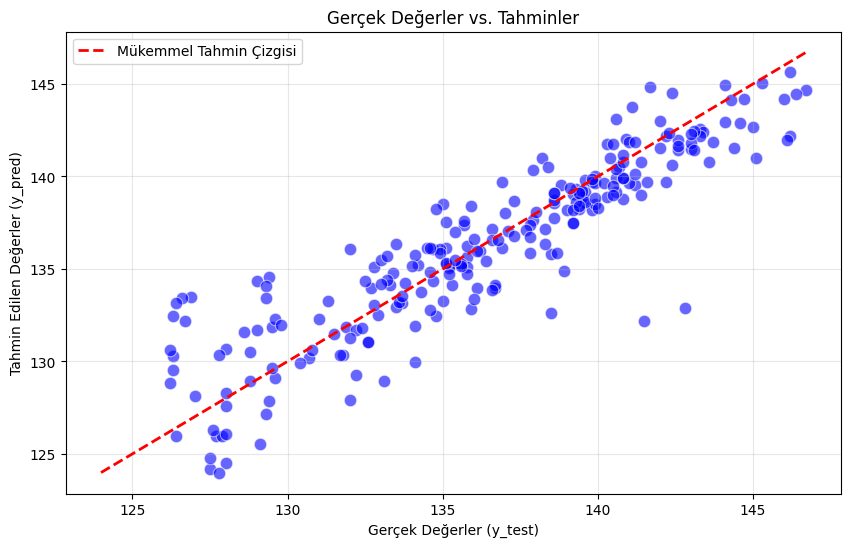

In [19]:
plt.figure(figsize=(10, 6))

# Gerçek ve Tahmin edilen değerleri saçılım grafiği olarak çiz
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue', edgecolor='w', s=80)

# İdeal Referans Çizgisi (y = x)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Mükemmel Tahmin Çizgisi')

plt.title('Gerçek Değerler vs. Tahminler')
plt.xlabel('Gerçek Değerler (y_test)')
plt.ylabel('Tahmin Edilen Değerler (y_pred)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
plt.scatter(y_test, y_pred_test_final_2, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual DO (%sat)')
plt.ylabel('Predicted DO (%sat)')
plt.title(f'Original Model\nTest R² = {r2_score(y_test, y_pred_test):.4f}')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()